In [8]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [9]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [10]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [11]:
import numpy as np
from tqdm import tqdm

def calculate_trans_p(traj):
    """
    Calculates the cumulative trans population and standard error per timepoint.
    
    Parameters
    ----------
    traj : np.ndarray
        A 2D array of shape (timesteps, residues), where values are either 0 (cis) or 1 (trans).

    Returns
    -------
    trans_population : np.ndarray
        Running trans population per residue (same shape as input).
    
    trans_population_err : np.ndarray
        Standard error of trans population (same shape).
    """

    trans_population = np.zeros_like(traj, dtype=float)
    trans_population_err = np.zeros_like(traj, dtype=float)
    n_res = traj.shape[1]
    n_time = traj.shape[0]

    for res_idx in tqdm(range(n_res), desc="Calculating trans populations", ncols=100):
        trans_count = 0

        for j in range(n_time):
            val = traj[j, res_idx]

            if val == 1:
                trans_count += 1

            p = trans_count / (j + 1)
            trans_population[j, res_idx] = p
            trans_population_err[j, res_idx] = np.sqrt(p * (1 - p) / (j + 1))

    print('Trans population shape:', trans_population.shape)
    print('Trans population error shape:', trans_population_err.shape)
    return trans_population, trans_population_err


## The Trans Population overtime Plot

In [12]:
omega_all_state = []

for i in range(6):
    omega_state = np.array(Data.load(f'omega_data/omegas_state{i}.pkl').array_list)
    omega_all_state.append(omega_state)

omega_all_state = np.array(omega_all_state)
omega_all_state.shape


(6, 600030, 3)

In [13]:
ntraj = len(omega_all_state)
print('np.array(omega_all_state).shape', np.array(omega_all_state).shape)

cistrans = omega2cistrans(omega_all_state)
print('cistrans.shape', cistrans.shape)

cistrans[0, :10, :]

np.array(omega_all_state).shape (6, 600030, 3)
cistrans.shape (6, 600030, 3)


array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [14]:
trans_all_population = []
trans_all_population_err = []

for state in range(6):
    traj = cistrans[state]
    trans_population, trans_population_err = calculate_trans_p(traj)
    
    trans_all_population.append(trans_population)
    trans_all_population_err.append(trans_population_err)

trans_all_population = np.array(trans_all_population)
trans_all_population_err = np.array(trans_all_population_err)

print('trans_all_population.shape', trans_all_population.shape)
print('trans_all_population_err.shape', trans_all_population_err.shape)

Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.66s/it]


Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:04<00:00,  1.58s/it]


Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)


Calculating trans populations: 100%|██████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

Trans population shape: (600030, 3)
Trans population error shape: (600030, 3)
trans_all_population.shape (6, 600030, 3)
trans_all_population_err.shape (6, 600030, 3)


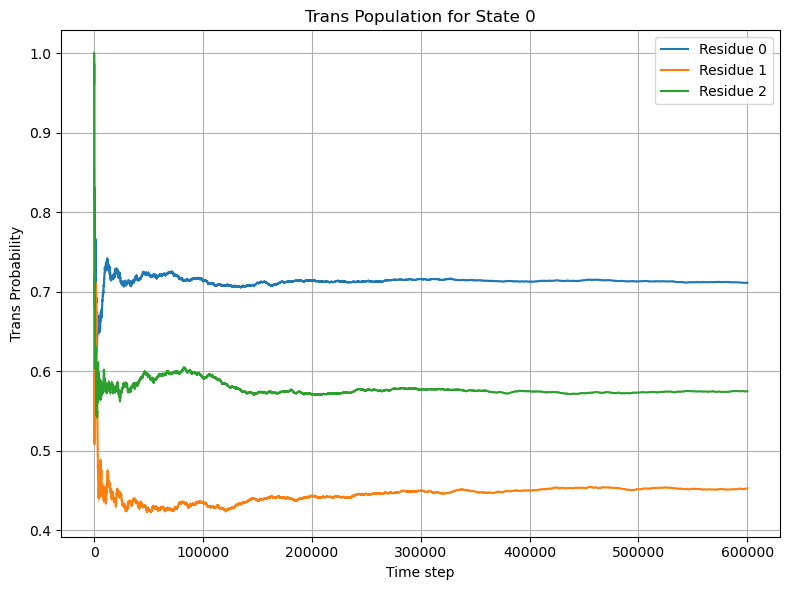

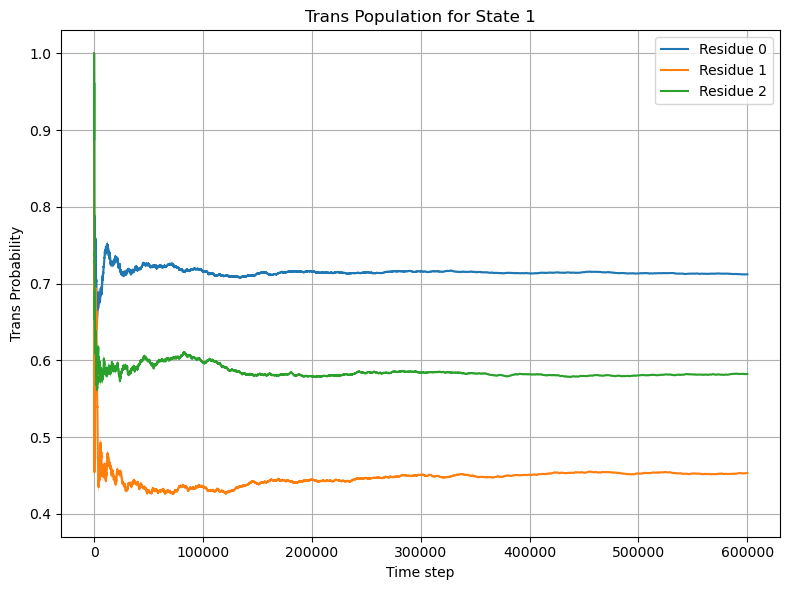

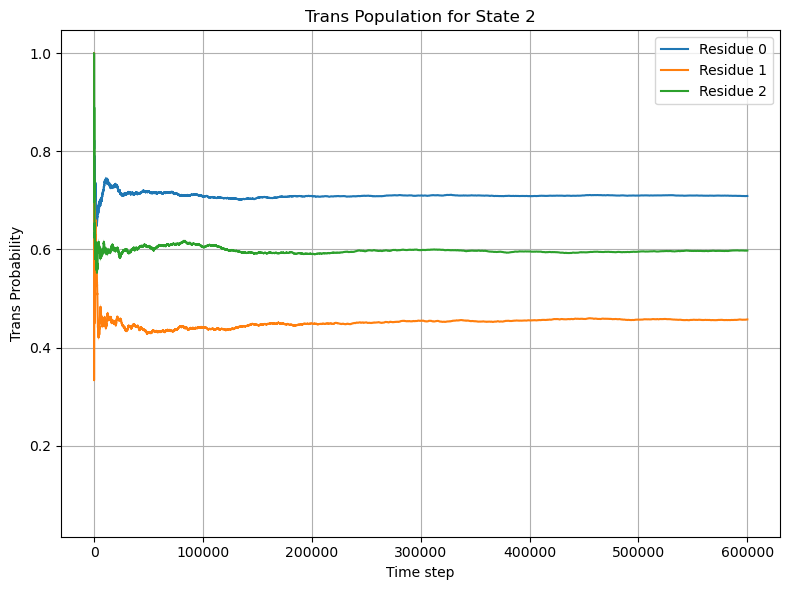

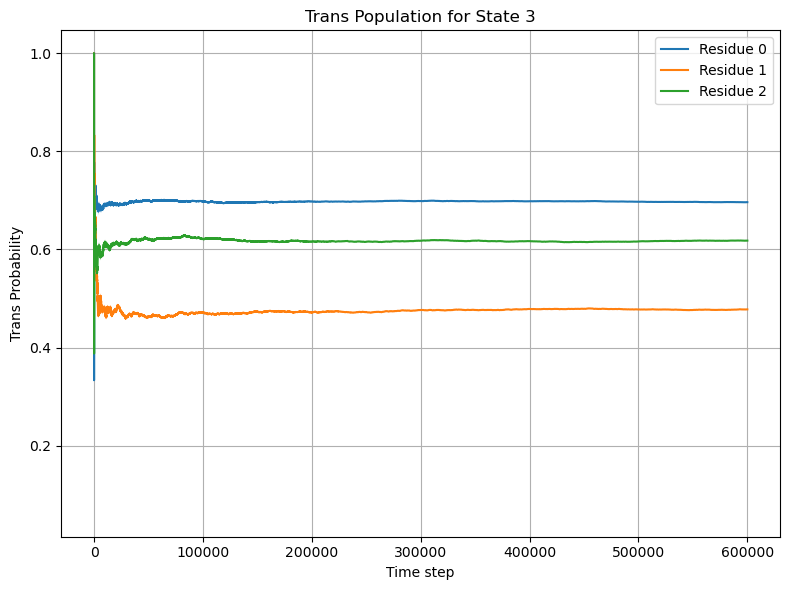

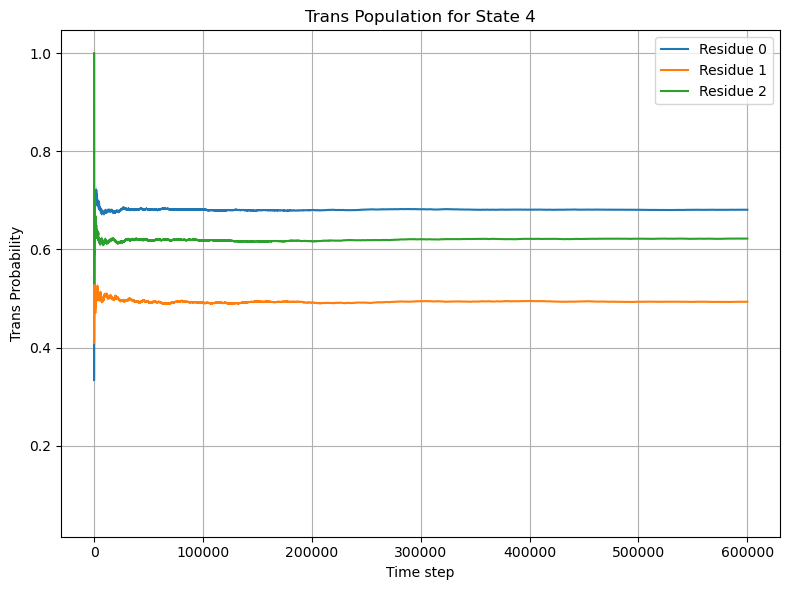

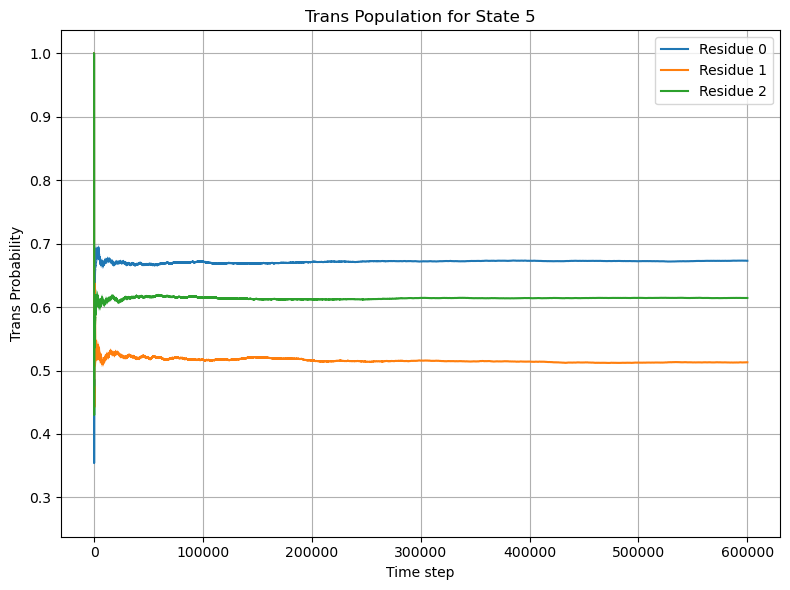

In [15]:
for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use actual time values

        plt.plot(x, y, label=f'Residue {residue_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


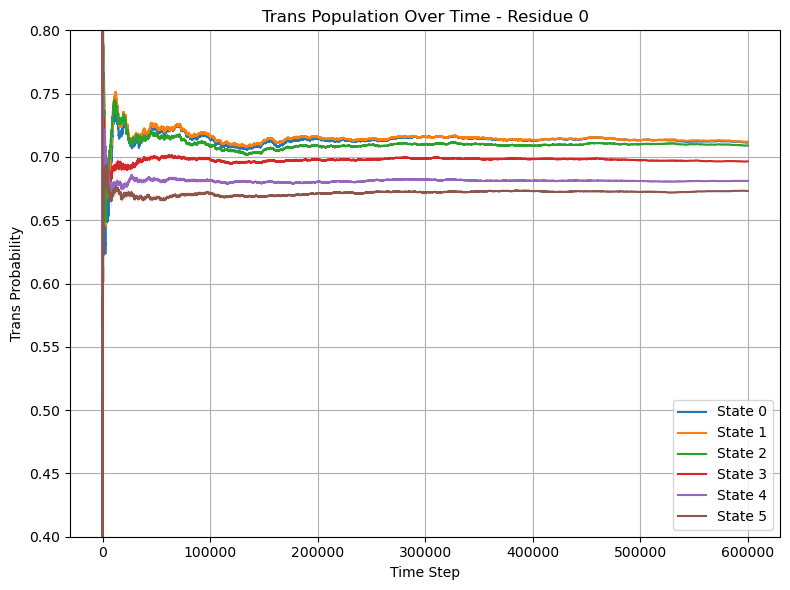

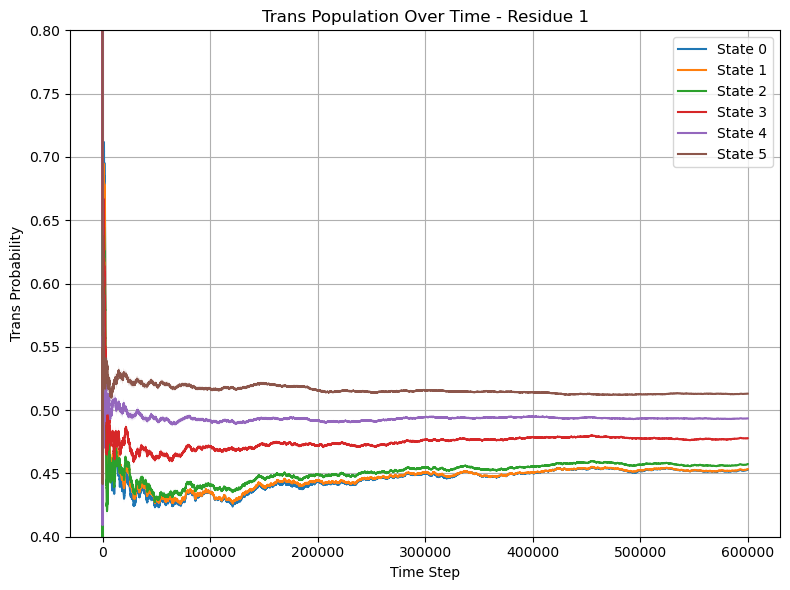

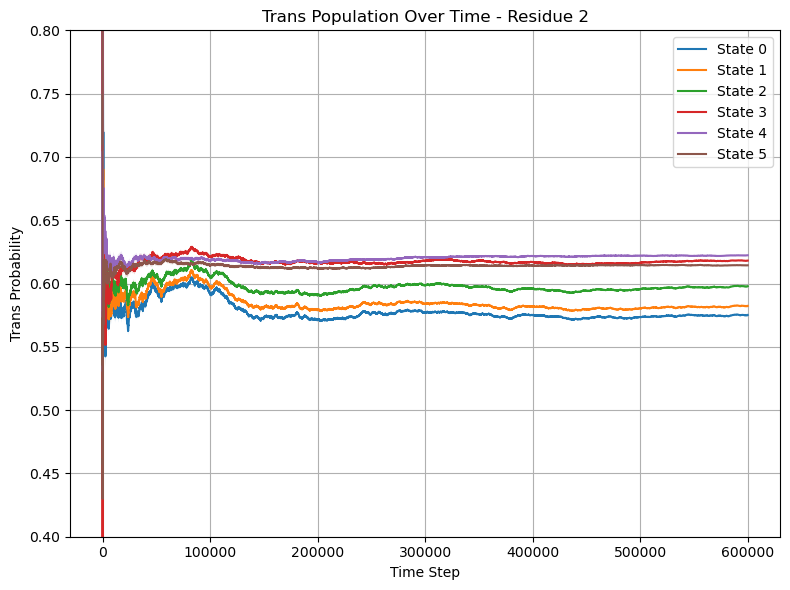

In [16]:
for residue_index in range(3):  # 3 residues
    plt.figure(figsize=(8, 6))

    for state_index in range(6):  # 6 states
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use lagtimes or time array if available

        plt.plot(x, y, label=f'State {state_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    plt.title(f'Trans Population Over Time - Residue {residue_index}')
    plt.xlabel('Time Step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.ylim(0.4, 0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Error Over Times

In [17]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array.shape
trans_refer_array

array([[0.71117513, 0.45312544, 0.57496868],
       [0.71156474, 0.45335854, 0.58222273],
       [0.70857515, 0.45747069, 0.5978815 ],
       [0.69657916, 0.47797034, 0.61814637],
       [0.68110719, 0.49322711, 0.62237576],
       [0.67307019, 0.51288994, 0.61450621]])

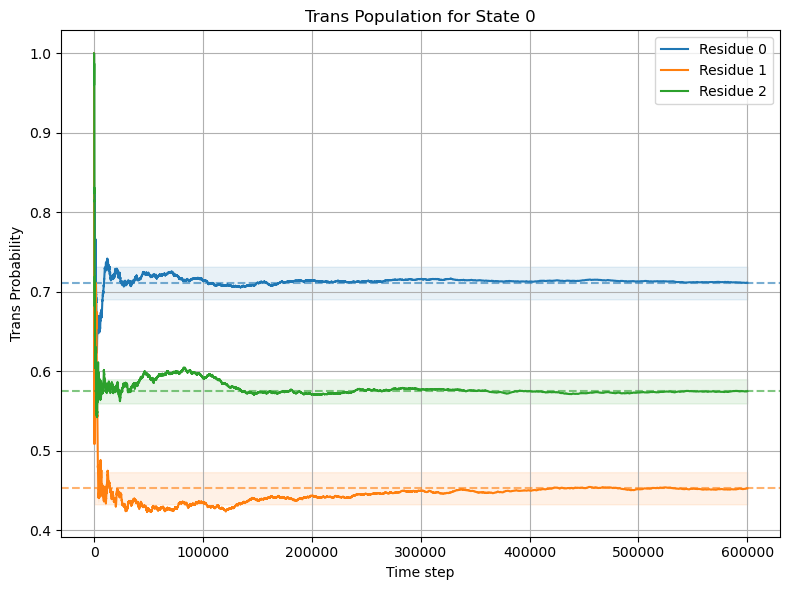

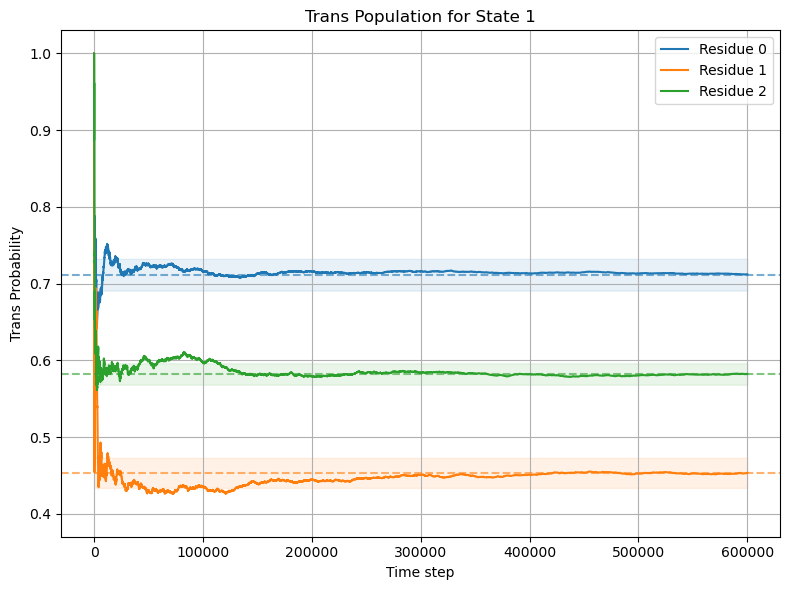

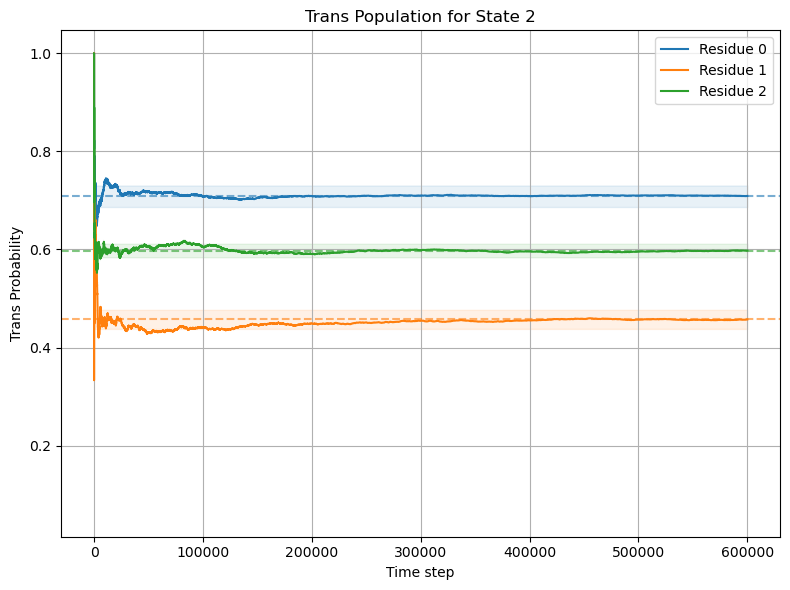

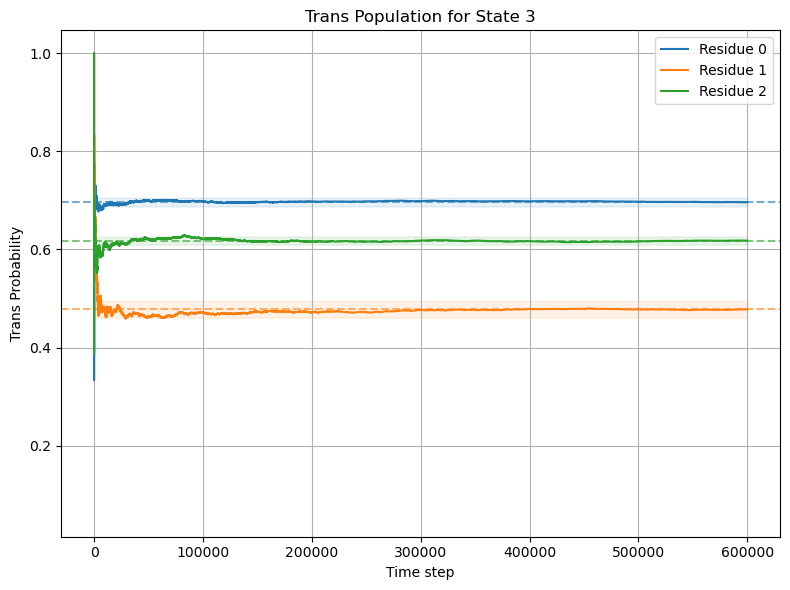

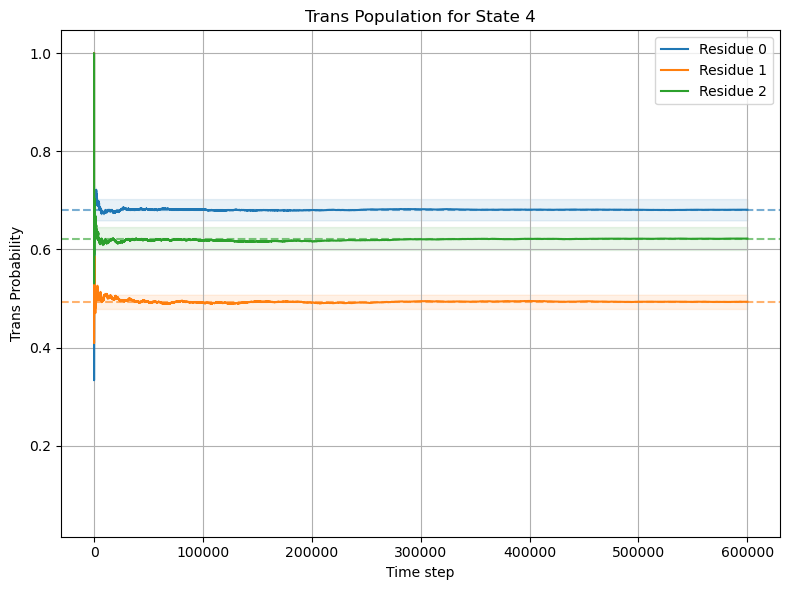

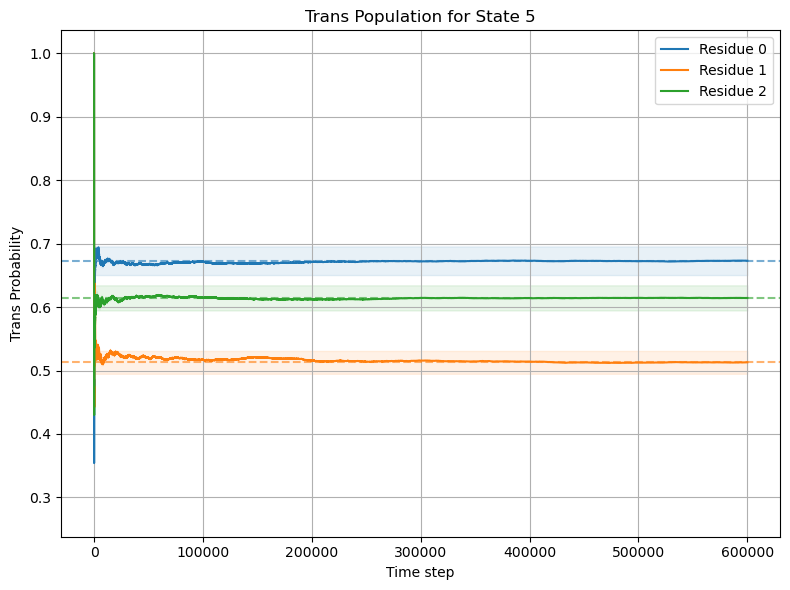

In [18]:
for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use actual time values

        # Time-dependent population
        plt.plot(x, y, label=f'Residue {residue_index}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference horizontal line
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        plt.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


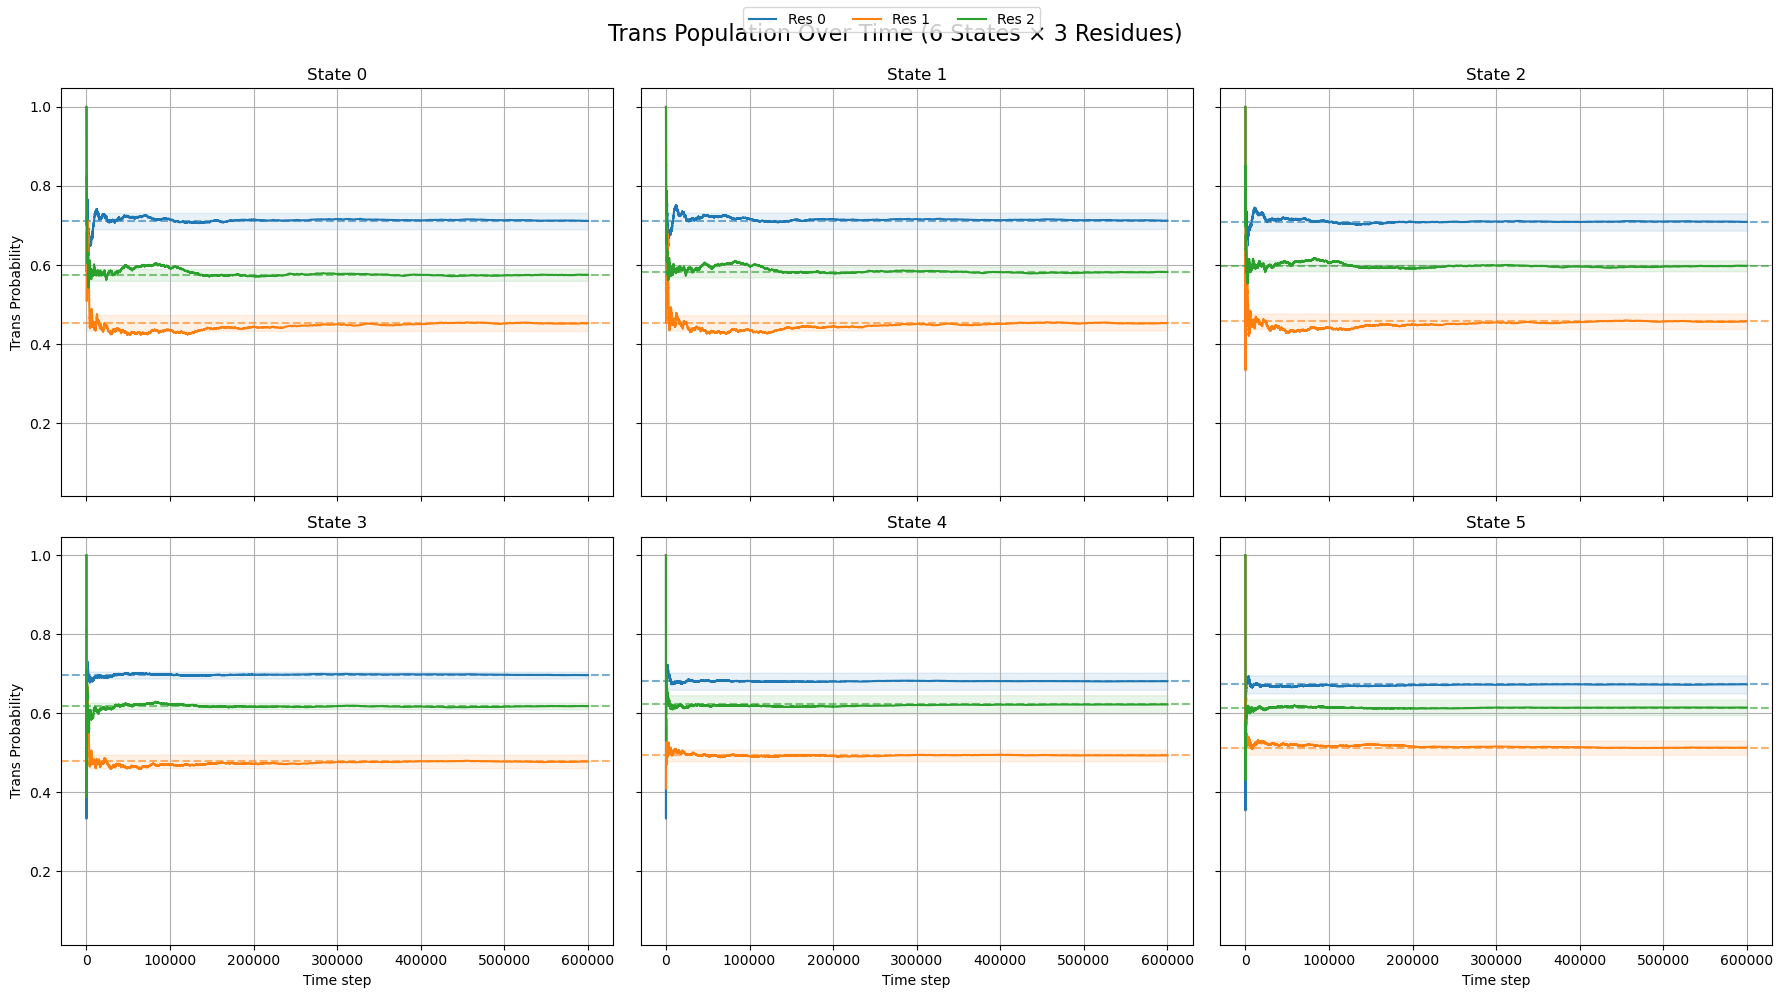

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index 0 through 5

for state_index in range(6):  # 6 states → 2x3 grid
    ax = axes[state_index]
    
    for residue_index in range(3):  # 3 residues
        y = trans_all_population[state_index, :, residue_index]
        yerr = trans_all_population_err[state_index, :, residue_index]
        x = np.arange(len(y))  # or use time array if available

        # Time-dependent curve
        ax.plot(x, y, label=f'Res {residue_index}')
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Reference line and shaded error
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]
        ax.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        ax.fill_between(x, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{residue_index}', alpha=0.1)

    ax.set_title(f'State {state_index}')
    ax.grid(True)
    if state_index >= 3:
        ax.set_xlabel('Time step')
    if state_index % 3 == 0:
        ax.set_ylabel('Trans Probability')

# Shared legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)

plt.suptitle("Trans Population Over Time (6 States × 3 Residues)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


### Plot the ERROR

In [20]:
errors_all = []
errors_err_all = []


for res in range(3):
    # Broadcast reference to (6, 600030)
    reference = trans_refer_array[:, res][:, np.newaxis]
    reference_err = trans_refer_err_array[:, res][:, np.newaxis]

    # Compute differences and propagated error
    errors = trans_all_population[:, :, res] - reference
    errors_err = np.sqrt(
        trans_all_population_err[:, :, res]**2 + reference_err**2
    )

    errors_all.append(errors)
    errors_err_all.append(errors_err)

    #plt.plot(errors)
    #plt.show()

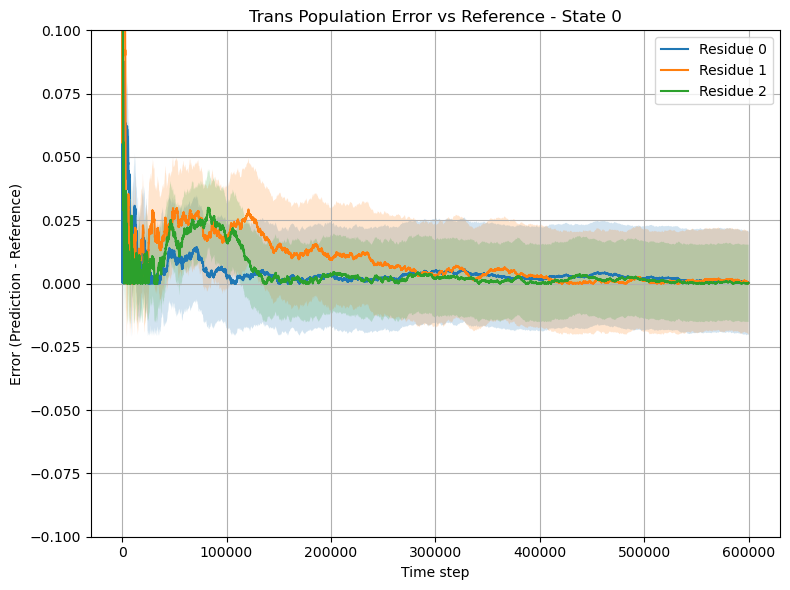

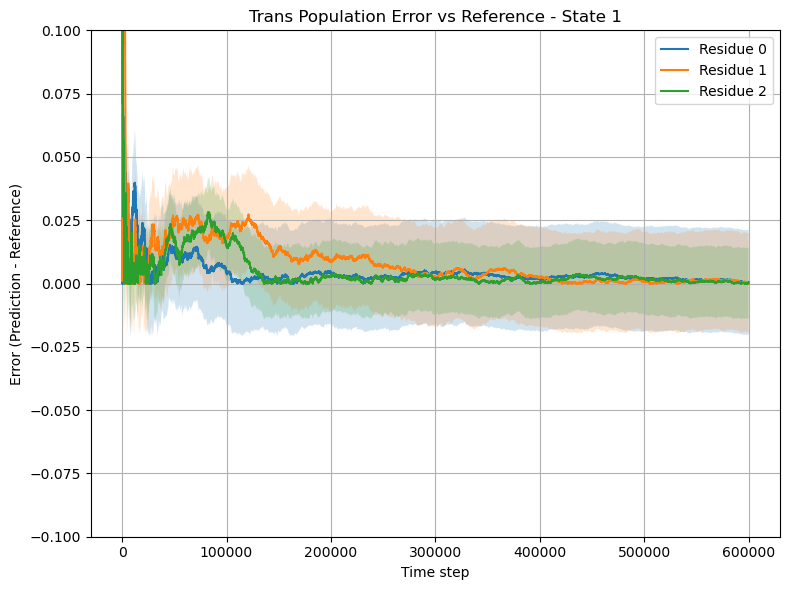

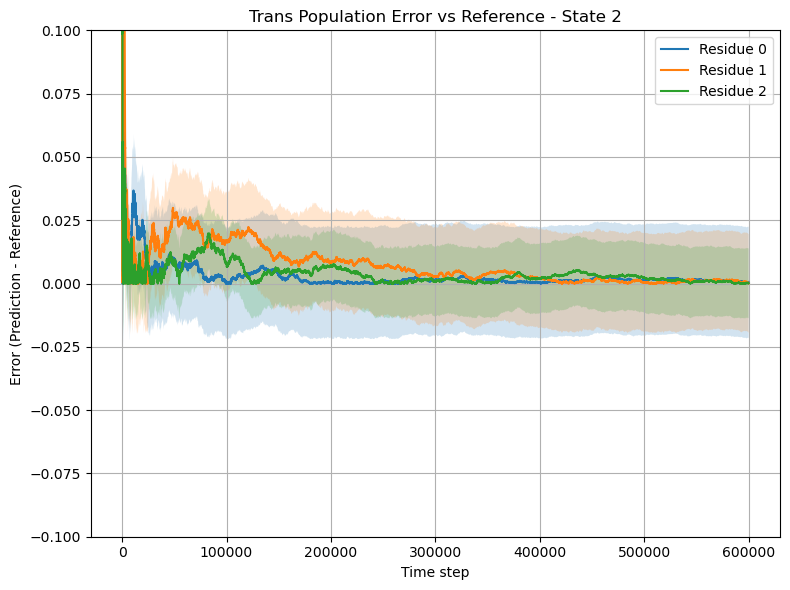

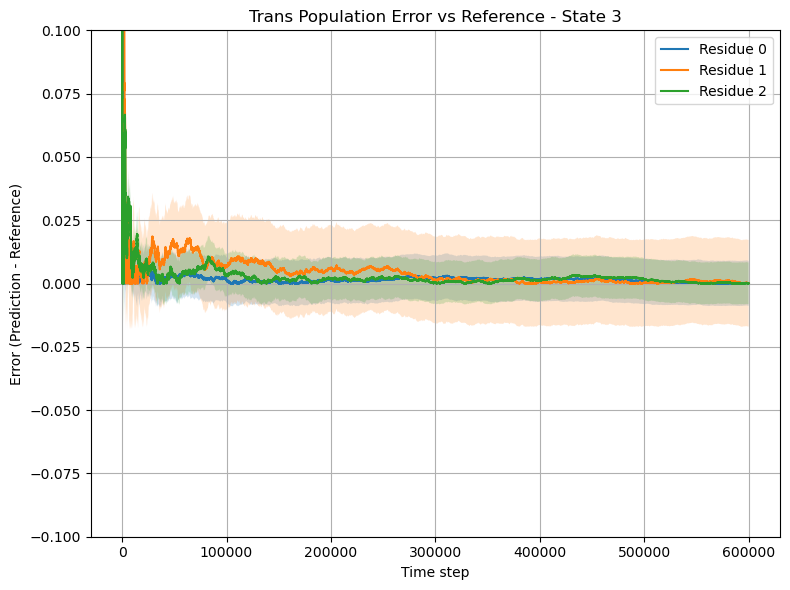

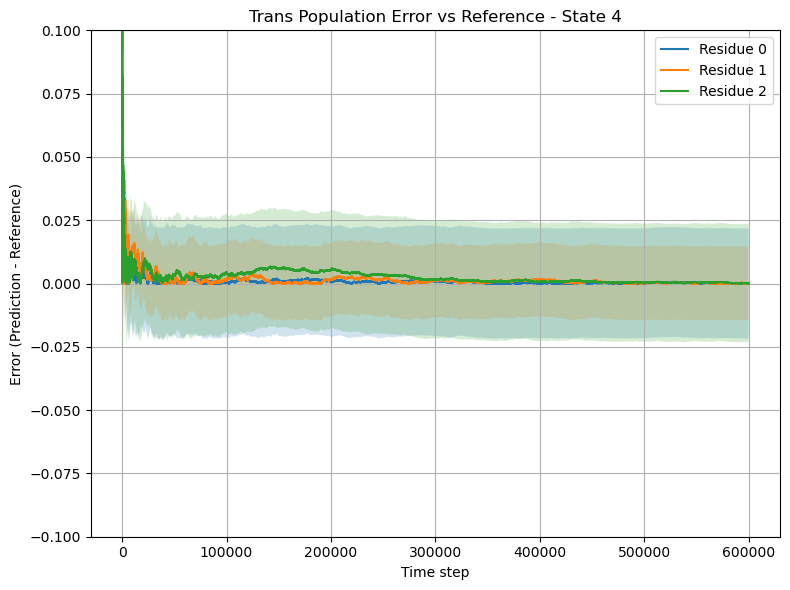

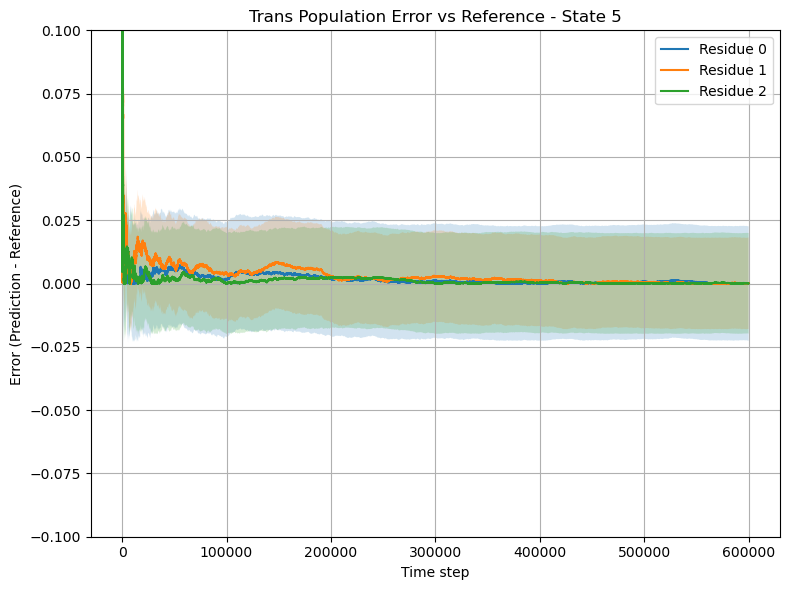

In [26]:
for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(8, 6))
    
    x = np.arange(trans_all_population.shape[1])  # Time axis, e.g., 600030

    for residue_index in range(3):  # Loop over 3 residues
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        
        error = np.abs(error) # Take the abs value
        
        error_err = np.sqrt(
            trans_all_population_err[state_index, :, residue_index] ** 2 +
            trans_refer_err_array[state_index, residue_index] ** 2  
        )

        plt.plot(x, error, label=f'Residue {residue_index}')
        plt.fill_between(x, error - error_err, error + error_err, alpha=0.2)

    plt.title(f'Trans Population Error vs Reference - State {state_index}')
    plt.xlabel('Time step')
    plt.ylabel('Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.1, 0.1)
    plt.tight_layout()
    plt.show()


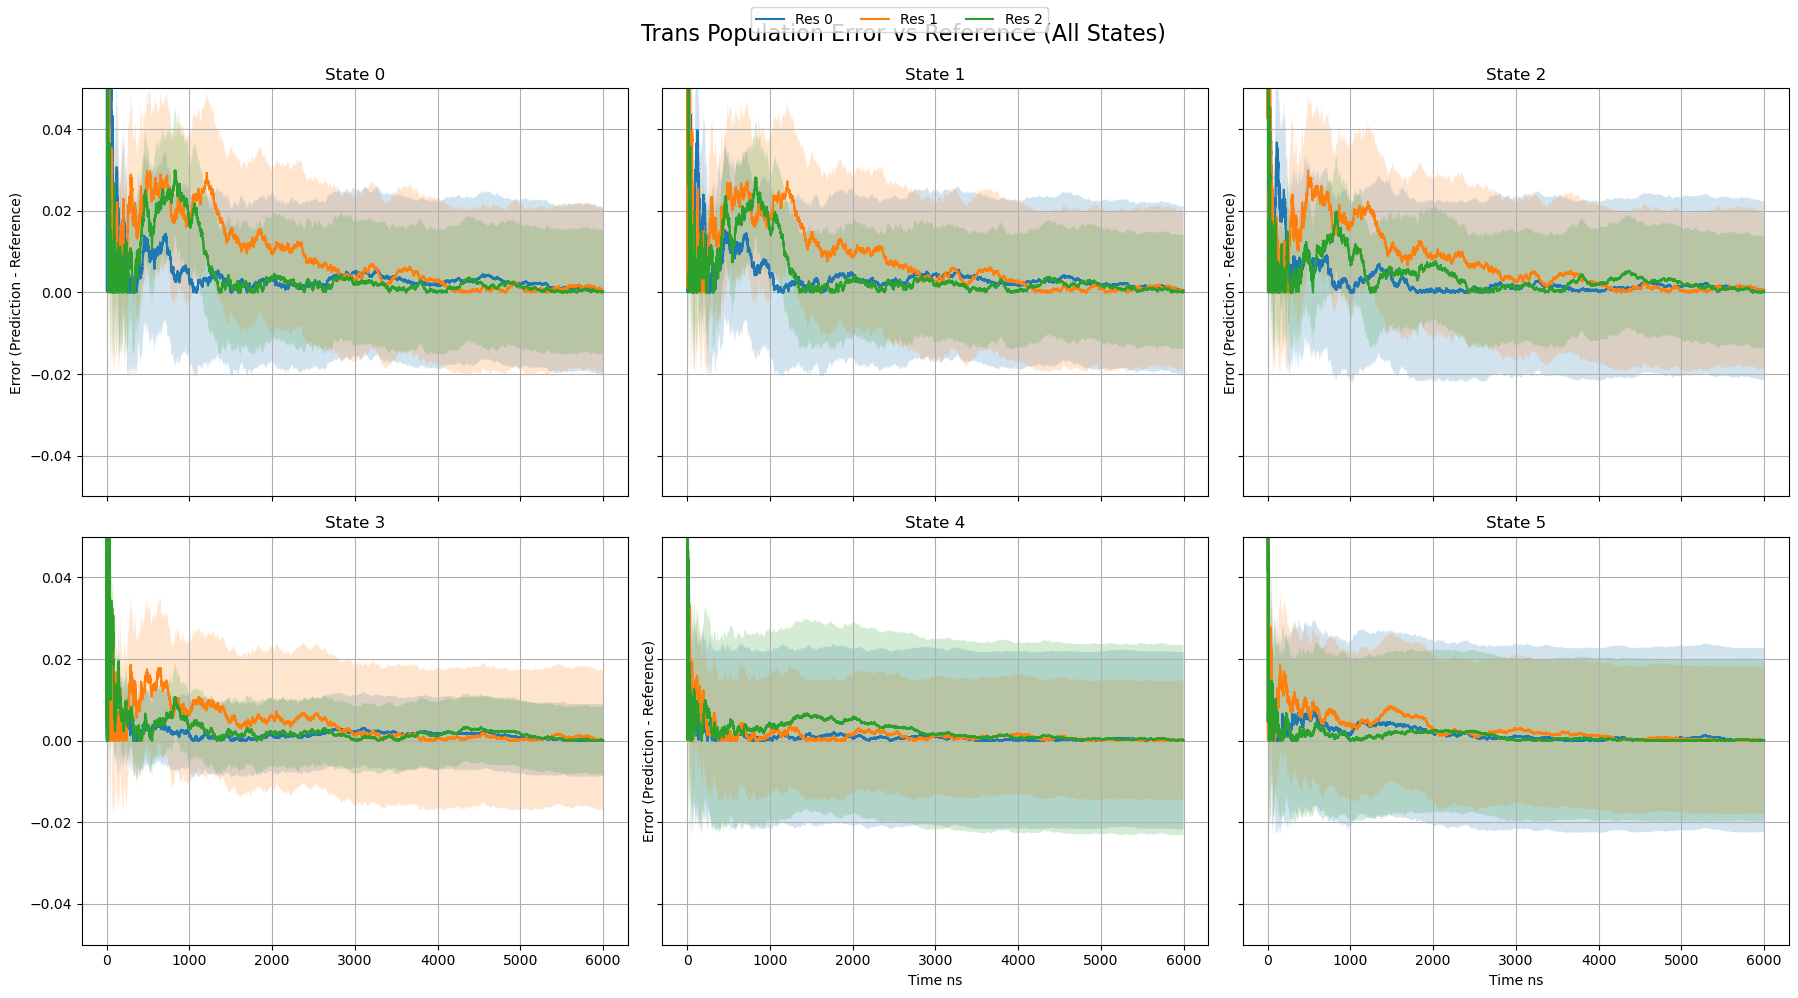

In [27]:
dt_in_ns = 0.01

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

x = np.arange(trans_all_population.shape[1])  # Time axis

for state_index in range(6):
    ax = axes[state_index]

    for residue_index in range(3):
        error = trans_all_population[state_index, :, residue_index] - trans_refer_array[state_index, residue_index]
        
        error = np.abs(error) # Take the abs value
        
        error_err = np.sqrt(
            trans_all_population_err[state_index, :, residue_index]**2 +
            trans_refer_err_array[state_index, residue_index]**2
        )

        ax.plot(x * dt_in_ns, error, label=f'Res {residue_index}')
        ax.fill_between(x * dt_in_ns, error - error_err, error + error_err, alpha=0.2)

    ax.set_title(f'State {state_index}')
    ax.grid(True)
    if state_index // 2 == 2:
        ax.set_xlabel('Time ns')
    if state_index % 2 == 0:
        ax.set_ylabel('Error (Prediction - Reference)')

# Add a global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)
fig.suptitle("Trans Population Error vs Reference (All States)", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ylim(-0.05, 0.05)  # Or any range you like
plt.show()
